In [1]:
import pandas as pd
import numpy as np

In [2]:
marketing_campaign = pd.read_csv('data/marketing_campaign.csv')
marketing_campaign

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


In [3]:
marketing_campaign.variant.value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

In [4]:
marketing_campaign.converted.value_counts()

False    8946
True     1076
Name: converted, dtype: int64

In [5]:
def encoderBin(feature):
    return 1 if feature else 0

In [6]:
marketing_campaign['converted'] = marketing_campaign['converted'].apply(encoderBin)

In [7]:
marketing_campaign.head(2)

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,1
1,a1001,1/1/18,House Ads,personalization,English,1


In [8]:
X_A = marketing_campaign.loc[marketing_campaign['variant'] == 'personalization']
X_B = marketing_campaign.loc[~(marketing_campaign['variant'] == 'personalization')]

In [30]:
X_A.describe()

,converted
count,4946.000000
mean,0.142539
std,0.349638
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [31]:
X_B.describe()

,converted
count,5091.000000
mean,0.075820
std,0.264736
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
X_A.converted.value_counts()

0    4241
1     705
Name: converted, dtype: int64

In [12]:
X_B.converted.value_counts()

0    4705
1     386
Name: converted, dtype: int64

В выборке X_A процент первого класса в таргете - 16%, тоже самое в выборке X_B - 8%. Различия на лицо. Подтвердим это статистическими показателями.

In [14]:
k1, n1 = np.sum(X_A['converted']), X_A.shape[0]
k2, n2 = np.sum(X_B['converted']), X_B.shape[0]
k1, k2, n1, n2

(705, 386, 4946, 5091)

Выдвинем гипотезу H0 утверждающую, что различия в выборках X_A и X_B статистически не значимы, и гипотезу H1, утверждающую, что различия в выборках статистически значимы. 

Признак converted номинальный, поэтому применим z-критерий.

Произведем ресчет критерия по формулам, затем проверим результат используя стат-библиотеки.


$$Z(X_1^{n_1}, X_2^{n_2}) = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1-P)(\frac{1}{n_1} + \frac{1}{n_2})}}, P = \frac{\hat{p}_1n_1 + \hat{p}_2n_2}{n_1+n_2}$$

In [33]:
z_crit_value = 1.96 # соответствует доверительному интервалу в 95%

In [20]:
p1, p2 = k1/n1, k2/n2
p1, p2

(0.14253942579862516, 0.07582007464152425)

In [21]:
P = (p1*n1 + p2*n2) / (n1 + n2)
z = (p1 - p2) / (P * (1 - P) * (1/n1 + 1/n2))**(1/2)
z

10.736322749559514

In [34]:
if abs(z) > z_crit_value:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We may reject the null hypothesis!


Отвергаем гипотезу H0 и принимаем гипотезу H1 утверждающую, что различия между выборками статистически значимы.

Проверим используя статистические библиотеки.

In [19]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=10.736 pvalue=0.000


In [17]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                        np.array([n1, n2]))

print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=115.269 pvalue=0.000


Находим подтверждение произведенных расчетов. Гипотеза Н0 - отвергается - различия статистически значимы.

Отобразим графически.

In [35]:
grouped = marketing_campaign.pivot_table(values='converted', index='variant', aggfunc=['sum', 'count'])
grouped

,sum,count
,converted,converted
variant,,
control,386,5091
personalization,705,4946


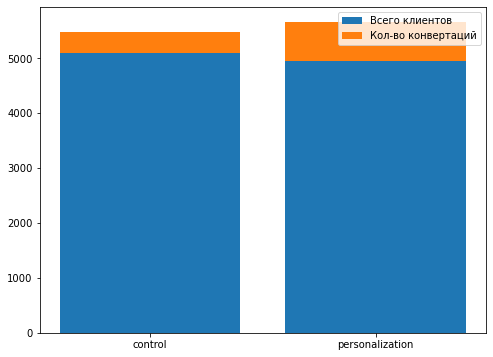

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar([1, 2], grouped['count']['converted'], label='Всего клиентов')
plt.bar([1, 2], grouped['sum']['converted'], bottom=grouped['count']['converted'], label='Кол-во конвертаций')
plt.xticks([1, 2], ['control', 'personalization'])
plt.legend();

Визуально видим различия в выборках, подтверждения которых получили статистическими выкладками.

In [38]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                        np.array([n1, n2]))

print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=115.269 pvalue=0.000


Третье подтверждение используя непараметрический критерий хи-квадрат о не верности гипотезы Н0.